In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from classifier import *
import features as fe 
import utils as ut

In [2]:
X_train_face_img, X_train_nonface_img, X_test_img, y_train_face, y_train_nonface, y_test = ut.get_test_train_data()

### Testing AdaBoost

In [3]:
X_train_img = np.concatenate((X_train_face_img, X_train_nonface_img))
y_train = np.concatenate((y_train_face, y_train_nonface))
X_train_ada, y_train_ada = ut.random_subset(X_train_img, y_train, 100)
X_test_ada, y_test_ada = ut.random_subset(X_test_img, y_test, 100)

In [4]:
rect = fe.get_rectanges(19, 19)
no_rect = fe.get_no_rectangles(19, 19)
X_train_ada_fe = fe.feature_extraction_images(X_train_ada, rect, no_rect)
X_test_ada_fe = fe.feature_extraction_images(X_test_ada, rect, no_rect)

In [5]:
a = AdaBoostClassifier()
a.fit(X_train_ada_fe, y_train_ada, 2)

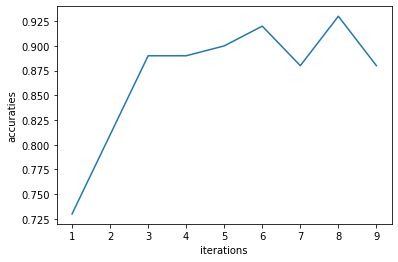

In [6]:
iters = list(range(1, 10))
accuracies = []
a = AdaBoostClassifier()
for iter in iters:
    a.fit(X_train_ada_fe, y_train_ada, iter)
    accuracy = a.score(X_test_ada_fe, y_test_ada)
    accuracies.append(accuracy)

plt.xlabel("iterations")
plt.ylabel("accuraties")
plt.plot(iters, accuracies)
plt.show()